In [1]:
from sqlalchemy.orm.session import sessionmaker
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import json
from operator import itemgetter
import scipy as sp
import sklearn as sk
from sklearn.metrics import classification_report
import tensorflow_probability as tfp
%matplotlib inline

tf.random.set_seed(5)

In [2]:
tf.__version__

'2.5.0'

# <p style="font-size:60px;color:white;font-family:'Courier New'" >SYSCLIENT 0201 ANALYSIS</p>

- Here we shall first load the cleaned and sorted graph in JSON format and then preprocess the data to get a preformatted data.
- After that we shall use the preformatted data to generate a data generator pipeline
- The new model will be a *MULTI-INPUT* and **SINGLE OUTPUT** model. 


In [5]:
actor_id_to_id_filename = '/mnt/8tb/csenrc/data/ecar/benign/actors_to_id.csv'
query_by_id = "select * from \"SysClient0201Events\" where \"id\"=\'{}\';"
db_url = 'postgresql+psycopg2://csephase2:csephase@@localhost/csephase2'
event_count = 19230658

psql_engine = create_engine(db_url)
Session = sessionmaker(bind=psql_engine)
session = Session()

sysclient0201_sorted_graph_path = '/mnt/8tb/csenrc/data/ecar/benign/dirty_sorted_graph201.json' #shahrear: what is in this json file, checking construct_graph.ipynb

In [6]:
sysclient_0201_graph = dict()
with open(sysclient0201_sorted_graph_path,'r') as graph_file:
    sysclient_0201_graph = json.load(graph_file)
graph_file.close()

# Based on the loaded graph which contains parent->child relationship, we shall construct a graph that contains child->parent relationship.

```
*We name it as back_graph*
```

In [9]:
back_graph = dict()
printi = 0
for key in sysclient_0201_graph:
    if printi == 0:
        print (key, sysclient_0201_graph[key])
        printi = 1
    children = sysclient_0201_graph[key]
    for child in children:
        if printi == 1:
            print (child)
            print (child[0])
            printi = 2
        back_graph[child[0]] = int(key)

8929953 [[8931456, 0.5, 0.8, 0.00010837658677218151], [8931457, 0.5, 0.8, 0.00010837658677218151], [8931458, 0.5, 0.8, 0.00010837954255101674], [8931459, 0.5, 0.8, 0.00010837954255101674], [8931460, 0.5, 0.8, 0.00010838249832985195], [8931461, 0.5, 0.8, 0.00010838545410868716], [8931462, 0.5, 0.8, 0.00010838545410868716], [8931463, 0.5, 0.8, 0.00010838545410868716], [8931464, 0.5, 0.8, 0.00010838545410868716], [8931465, 0.5, 0.8, 0.00010839136566635761], [8931466, 0.5, 0.8, 0.00010839136566635761], [8931467, 0.5, 0.8, 0.00010839432144519283], [8931468, 0.5, 0.8, 0.00010839432144519283], [8931469, 0.5, 0.8, 0.00010839727722402806], [8931470, 0.5, 0.8, 0.00010839727722402806], [8931471, 0.5, 0.8, 0.00010840023300286328], [8931472, 0.5, 0.8, 0.00010840023300286328], [8931474, 0.5, 0.8, 0.00010840614456053371], [8931473, 0.5, 0.8, 0.00010840910033936893], [8931475, 0.5, 0.8, 0.00010840910033936893], [8931476, 0.5, 0.8, 0.00010841205611820415], [8931477, 0.5, 0.8, 0.00010841205611820415], [

# Now it is time to perform a massive preprocessing operation

- Consider a dictionary with the keys that represent the parent nodes.
- The entries of this dict is another dictionary which contains the child nodes as keys 
- In this nested dictionary, each child is mapped to a numpy vector of length 13 
- The first 3 entries contain the child object type, action type and time difference between parent and child event.
- The next 5 entries contain the difference between expected number of events at that time and actual number of events at that time. This can be explained from the definition of `Poisson_Distribution`. Please refer to the paper for detailed discussion. 
- The next 5 entries contain the wait time for the next event. This again can be explained from the `Poisson_Distribution`. Refer to paper for explanation details. 

Once this preprocessing is complete we start writing the generator.

In [10]:
def preprocess_adjacency_list(adjacency_list):
    """This will return a dict that contains the preprocessed data.

    Args:
        adjacency_list ([list]): Adjacency list extracted from the dirty sorted graph.
    """

    adjacency_dict = dict()

    if len(adjacency_list) == 0:
        return adjacency_dict

    num_process_open = 0
    num_process_create = 0
    num_file = 0
    num_flow = 0
    num_shell = 0

    for node in adjacency_list: #shahrear: what is in this node? Each child?

        adjacency_dict[node[0]] = np.zeros(13)

        if node[1] == 0.5 and node[2] == 0.1:
            num_process_create +=1
        elif node[1] == 0.5 and node[2] == 0.8:
            num_process_open += 1
        elif node[1] == 0.25:
            num_file +=1
        elif node[1] == 0.75:
            num_shell += 1
        elif node[1] == 1.0:
            num_flow += 1

        adjacency_dict[node[0]][0] = node[1]
        adjacency_dict[node[0]][1] = node[2]
        adjacency_dict[node[0]][2] = node[3]

    delta_time = adjacency_list[-1][3]

    if delta_time == 0: # Just a precaution to avoid floating point error
        delta_time = 0.000001

    mean_process_open = num_process_open/delta_time
    mean_process_create = num_process_create/delta_time
    mean_file = num_file/delta_time
    mean_flow = num_flow/delta_time
    mean_shell = num_shell/delta_time

    mean_count = np.array([mean_process_open, mean_process_create, mean_file, mean_flow, mean_shell])
    event_count = np.zeros(5) # event count of process_open, process_create, file, flow, shell 

    #print(mean_count)
    
    prev_popen_time = 0
    prev_pcreate_time = 0 
    prev_file_time = 0
    prev_shell_time = 0
    prev_flow_time = 0
    
    
    for node in adjacency_list:

        diff_count = np.zeros(5)
        probs = np.zeros(5)
    
        if node[1] == 0.5 and node[2] == 0.1:
            #This is process create: index 1
            probs[1] = 1 - np.exp(-(mean_process_create*(node[3] - prev_pcreate_time)))

            probs[0] = np.exp(-(mean_process_open*(node[3] - prev_popen_time)))
            probs[2] = np.exp(-(mean_file*(node[3] - prev_file_time)))
            probs[3] = np.exp(-(mean_flow*(node[3] - prev_flow_time)))
            probs[4] = np.exp(-(mean_shell*(node[3] - prev_shell_time)))

            prev_pcreate_time = node[3]
            event_count[1] +=1

        elif node[1] == 0.5 and node[2] == 0.8:
            #This is process open: index 0 
            probs[0] = 1 - np.exp(-(mean_process_open*(node[3] - prev_popen_time)))
            
            probs[1] = np.exp(-(mean_process_create*(node[3] - prev_pcreate_time)))
            probs[2] = np.exp(-(mean_file*(node[3] - prev_file_time)))
            probs[3] = np.exp(-(mean_flow*(node[3] - prev_flow_time)))
            probs[4] = np.exp(-(mean_shell*(node[3] - prev_shell_time)))

            prev_popen_time = node[3]
            event_count[0] += 1

        elif node[1] == 0.25:
            # This is for file: index 2
            probs[2] = 1 - np.exp(-(mean_file*(node[3] - prev_file_time)))

            probs[0] = np.exp(-(mean_process_open*(node[3] - prev_popen_time)))
            probs[1] = np.exp(-(mean_process_create*(node[3] - prev_pcreate_time)))
            probs[3] = np.exp(-(mean_flow*(node[3] - prev_flow_time)))
            probs[4] = np.exp(-(mean_shell*(node[3] - prev_shell_time)))

            prev_file_time = node[3]
            event_count[2] +=1

        elif node[1] == 0.75:
            # This is for shell: index 4
            probs[4] = 1 - np.exp(-(mean_shell*(node[3] - prev_shell_time)))

            probs[2] = np.exp(-(mean_file*(node[3] - prev_file_time)))
            probs[0] = np.exp(-(mean_process_open*(node[3] - prev_popen_time)))
            probs[1] = np.exp(-(mean_process_create*(node[3] - prev_pcreate_time)))
            probs[3] = np.exp(-(mean_flow*(node[3] - prev_flow_time)))
            
            prev_shell_time = node[3]
            event_count[4] += 1

        elif node[1] == 1.0:
            # This is for flow: index 3
            probs[3] = 1 - np.exp(-(mean_flow*(node[3] - prev_flow_time)))

            probs[4] = np.exp(-(mean_shell*(node[3] - prev_shell_time)))
            probs[2] = np.exp(-(mean_file*(node[3] - prev_file_time)))
            probs[0] = np.exp(-(mean_process_open*(node[3] - prev_popen_time)))
            probs[1] = np.exp(-(mean_process_create*(node[3] - prev_pcreate_time)))
            
            prev_flow_time = node[3]
            event_count[3] += 1

        diff_count = (mean_count*node[3]) - event_count
        adjacency_dict[node[0]][3:8] = diff_count
        adjacency_dict[node[0]][8:13] = probs

    
    return adjacency_dict

In [11]:
print(preprocess_adjacency_list(sysclient_0201_graph['1']))

{2: array([ 0.5,  0.1,  0. ,  0. , -1. ,  0. ,  0. ,  0. ,  1. ,  0. ,  1. ,
        1. ,  1. ]), 37150: array([0.5       , 0.1       , 0.00469963, 0.        , 1.        ,
       0.        , 0.        , 0.        , 1.        , 0.95021293,
       1.        , 1.        , 1.        ]), 37151: array([0.5       , 0.1       , 0.00469963, 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       1.        , 1.        , 1.        ])}


In [12]:
preprocessed_sysclient_0201_graph = dict()
for key in sysclient_0201_graph:
    if int(key) != 0:
        children = sysclient_0201_graph[key]
        preprocessed_sysclient_0201_graph[int(key)] = preprocess_adjacency_list(children)

In [13]:
# handling the corner case of 0 in our graph 
preprocessed_sysclient_0201_graph[0] = dict()
children = sysclient_0201_graph['0']
for child in children:
    preprocessed_sysclient_0201_graph[0][child[0]] = np.hstack([np.array([child[1],child[2],0]), np.zeros(10)]) #shahrear: why are we preprocessing before the trace is generated?

# Now the preprocessing is done. Let's load the bad boys (aka malicious data points)

In [14]:
label_file = '/mnt/8tb/csenrc/data/ecar/benign/labels.csv'
label_df = pd.read_csv(label_file)
sysclient201_labels = label_df[label_df['hostname']=='SysClient0201.systemia.com']

In [15]:
malicious_events = dict()
query_event_id_actor_id = "select * from \"SysClient0201Events\" where \"actorID\"=\'{}\' and \"event_id\"=\'{}\';"
for idx,row in sysclient201_labels.iterrows():
    if row['object'] in ['PROCESS','FILE','SHELL']:
        result_set = session.execute(query_event_id_actor_id.format(row['actorID'],row['id']))
        for result in result_set:
            malicious_events[result.id] = result
    elif row['object'] == 'FLOW' and row['action']=='MESSAGE':
        result_set = session.execute(query_event_id_actor_id.format(row['actorID'],row['id']))
        for result in result_set:
            malicious_events[result.id] = result

In [16]:
print(len(malicious_events))

22919


In [17]:
def get_trace(start_node):
    trace = []
    temp_node = start_node
    trace.append(temp_node)
    while True:
        if temp_node in back_graph: #shahrear: when it is false? what about trace length l?
            temp_node = back_graph[temp_node]
            trace.append(temp_node)
        else:
            break
            
    return trace

In [18]:
malicious_event_traces = []

for node in malicious_events:
    malicious_event_traces.append(get_trace(node))


num = len(malicious_event_traces)
total = 0
max_len = -1
for trace in malicious_event_traces:
    total += len(trace)
    if len(trace)>max_len:
        max_len = len(trace)
print("Average trace length: {}".format(total/num))
print("Maximum Length of Trace: {}".format(max_len))

Average trace length: 19.077926611108687
Maximum Length of Trace: 22


In [19]:
benign_event_traces = []

count_benign_trace = 0
start_idx = 7000000
while count_benign_trace<500000:
    #get a random index
    rand_index = np.random.randint(start_idx, high = event_count)
    if rand_index not in malicious_events:
        if rand_index in back_graph:
            derived_trace = get_trace(rand_index)
            if derived_trace[-1] == 0:
                benign_event_traces.append(derived_trace)
                count_benign_trace+=1


benign_len = 0
benign_max_len = -1
for trace in benign_event_traces:
    benign_len += len(trace)
    if len(trace)>benign_max_len:
        benign_max_len = len(trace)
        
print("Average benign trace length:{}".format(benign_len/len(benign_event_traces)))
print("Maximum Benign Trace Length:{}".format(benign_max_len))

Average benign trace length:14.516562
Maximum Benign Trace Length:35


# We have the Benign Traces and The Malicious Traces. There are 22919 Malicious Trace Samples With Average length of 19.0779266. On the other hand, there are 500000 benign trace samples with average length of 14.521834. 

- We are going to split them into train and test set and then write a generator to produce batches for deep learning model

In [20]:
train_x_benign = benign_event_traces[:400000]
test_x_benign = benign_event_traces[400000:]

train_x_malicious = malicious_event_traces[:16000]
test_x_malicious = malicious_event_traces[16000:]

In [21]:
def transform_trace(trace, cutoff=8):
    numeric_trace = np.zeros((cutoff,13)) # Length of the trace and 13 corresponding points for each node
    
    for k in range(len(trace)):
        if trace[k] in back_graph:
            parent = back_graph[trace[k]]
            numeric_trace[k] = preprocessed_sysclient_0201_graph[parent][trace[k]]    

        if k==cutoff-1:
            break
    
    return numeric_trace

In [22]:
def train_generator( cutoff=8, batch_size = 32):
    while True:
        labels= np.random.randint(2,size=batch_size)
        num_malicious = np.sum(labels)
        num_benign = batch_size - num_malicious
        
        benign_data_indices = np.random.randint(0,high=400000, size = num_benign)
        malicious_data_indices = np.random.randint(0, high = 16000, size = num_malicious)

        benign_idx = 0
        malicious_idx = 0

        trace_cutoff = cutoff
        features = 13

        data = np.zeros((batch_size, trace_cutoff, features))
        idx = 0
        for label in labels:
            if label ==0:
                data[idx] = transform_trace(benign_event_traces[benign_data_indices[benign_idx]],cutoff=trace_cutoff)
                benign_idx += 1
                idx+=1
            elif label == 1:
                data[idx] = transform_trace(malicious_event_traces[malicious_data_indices[malicious_idx]],cutoff=trace_cutoff)
                malicious_idx += 1
                idx +=1 
        
        yield [data[:,:,:3],data[:,:,3:]], labels

# Now we shall define the baseline model. The model consists of LSTM layers for feature extraction followed by Dense Classification Layer

In [23]:
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import Input

In [24]:
def multi_head_lstm_model(input_shape1, input_shape2):
    input_layer1 = Input(shape = input_shape1)
    input_layer2 = Input(shape = input_shape2)
    
    x1 = layers.LSTM(32, return_sequences=True)(input_layer1)
    x2 = layers.LSTM(16, return_sequences=True)(input_layer2)

    x1 = layers.Flatten()(x1)
    x2 = layers.Flatten()(x2)

    x = layers.Concatenate()([x1,x2])

    x = layers.Dense(32,activation='relu')(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(16,activation='relu')(x)
    output_layer = layers.Dense(1, activation='sigmoid')(x)

    model = Model([input_layer1, input_layer2], output_layer)
    model.summary()

    return model

In [25]:
trace_length = 4
trace_dimension1 = 3
trace_dimension2 = 10
baseline_model = multi_head_lstm_model((trace_length,trace_dimension1),(trace_length,trace_dimension2))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
baseline_model.compile(optimizer=opt, loss = 'binary_crossentropy', metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 3)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4, 10)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 4, 32)        4608        input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 4, 16)        1728        input_2[0][0]                    
______________________________________________________________________________________________

In [26]:
train_gen = train_generator(cutoff=4, batch_size=1024)

In [27]:
history = baseline_model.fit_generator(train_gen, steps_per_epoch=10, epochs=10)

/home/monowar/anaconda3/envs/envphase2/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
10/10 [==============================] - 3s 27ms/step - loss: 0.6106 - accuracy: 0.8291
Epoch 2/10
10/10 [==============================] - 0s 27ms/step - loss: 0.4494 - accuracy: 0.9640
Epoch 3/10
10/10 [==============================] - 0s 26ms/step - loss: 0.2975 - accuracy: 0.9824
Epoch 4/10
10/10 [==============================] - 0s 26ms/step - loss: 0.1674 - accuracy: 0.9875
Epoch 5/10
10/10 [==============================] - 0s 23ms/step - loss: 0.0881 - accuracy: 0.9888
Epoch 6/10
10/10 [==============================] - 0s 26ms/step - loss: 0.0520 - accuracy: 0.9930
Epoch 7/10
10/10 [==============================] - 0s 26ms/step - loss: 0.0324 - accuracy: 0.9956
Epoch 8/10
10/10 [==============================] - 0s 23ms/step - loss: 0.0224 - accuracy: 0.9954
Epoch 9/10
10/10 [==============================] - 0s 24ms/step - loss: 0.0187 - accuracy: 0.9957
Epoch 10/10
10/10 [==============================] - 0s 23ms/step - loss: 0.0162 - accuracy: 0.9964


In [28]:
malicious_event_count_in_graph = 22919
def get_test_data():
    total_count = (malicious_event_count_in_graph-16000)+ 100000
    data = np.zeros((total_count, trace_length, 13))
    labels = np.hstack(( np.ones((malicious_event_count_in_graph-16000)), np.zeros(100000) ))
    
    idx = 0
    
    for i in range(16000, malicious_event_count_in_graph, 1):
        data[idx] = transform_trace(malicious_event_traces[i],cutoff=trace_length)
        idx+=1
    
    for i in range(400000,500000,1):
        data[idx] = transform_trace(benign_event_traces[i],cutoff=trace_length)
        idx+=1

    return [data[:,:,:3],data[:,:,3:]],labels

In [29]:
x_test, y_test = get_test_data()

In [30]:
y_pred = baseline_model.predict(x_test)
y_pred_bool = y_pred.round()
print(classification_report(y_test, y_pred_bool))  #shahrear: where is lstm1 and 2 and bnn?

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    100000
         1.0       0.99      1.00      0.99      6919

    accuracy                           1.00    106919
   macro avg       0.99      1.00      1.00    106919
weighted avg       1.00      1.00      1.00    106919



# <p style="font-size:60px;color:white;font-family:'Courier New'" >SYSCLIENT 0501 ANALYSIS</p>

In [31]:
sysclient0501_sorted_graph_path = '/mnt/8tb/csenrc/data/ecar/benign/dirty_sorted_graph501.json'
sysclient_0501_graph = dict()
with open(sysclient0501_sorted_graph_path,'r') as graph_file:
    sysclient_0501_graph = json.load(graph_file)
graph_file.close()

In [32]:
back_graph_501 = dict()
for key in sysclient_0501_graph:
    children = sysclient_0501_graph[key]
    for child in children:
        back_graph_501[child[0]] = int(key)

In [33]:
preprocessed_sysclient_0501_graph = dict()
for key in sysclient_0501_graph:
    if int(key) != 0:
        preprocessed_sysclient_0501_graph[int(key)] = preprocess_adjacency_list(sysclient_0501_graph[key])


preprocessed_sysclient_0501_graph[0] = dict()
children = sysclient_0501_graph['0']
for child in children:
    preprocessed_sysclient_0501_graph[0][child[0]] = np.hstack([np.array([child[1],child[2],0]), np.zeros(10)])

In [34]:
sysclient501_labels = label_df[label_df['hostname']=='SysClient0501.systemia.com']
print(len(sysclient501_labels))

27644


In [35]:
malicious_events_501 = dict()
query_event_id_actor_id = "select * from \"SysClient0501Events\" where \"actorID\"=\'{}\' and \"event_id\"=\'{}\';"
for idx,row in sysclient501_labels.iterrows():
    if row['object'] in ['PROCESS','FILE','SHELL']:
        result_set = session.execute(query_event_id_actor_id.format(row['actorID'],row['id']))
        for result in result_set:
            malicious_events_501[result.id] = result
    elif row['object'] == 'FLOW' and row['action']=='MESSAGE':
        result_set = session.execute(query_event_id_actor_id.format(row['actorID'],row['id']))
        for result in result_set:
            malicious_events_501[result.id] = result

In [36]:
print(len(malicious_events_501))

22928


In [37]:
def get_501trace(start_node):
    trace = []
    temp_node = start_node
    trace.append(temp_node)
    while True:
        if temp_node in back_graph_501:
            temp_node = back_graph_501[temp_node]
            trace.append(temp_node)
        else:
            break
            
    return trace

In [38]:
malicious501_event_traces = []

for node in malicious_events_501:
    malicious501_event_traces.append(get_501trace(node))


num = len(malicious501_event_traces)
total = 0
max_len = -1
for trace in malicious501_event_traces:
    total += len(trace)
    if len(trace)>max_len:
        max_len = len(trace)
print("Average trace length: {}".format(total/num))
print("Maximum Length of Trace: {}".format(max_len))
benign501_event_traces = []

count_benign_trace = 0
start_idx = 7000000

while count_benign_trace<500000:
    #get a random index
    rand_index = np.random.randint(start_idx, high = event_count)
    if rand_index not in malicious_events_501:
        if rand_index in back_graph_501:
            derived_trace = get_501trace(rand_index)
            if derived_trace[-1] == 0:
                benign501_event_traces.append(derived_trace)
                count_benign_trace+=1


benign_len = 0
benign_max_len = -1
for trace in benign501_event_traces:
    benign_len += len(trace)
    if len(trace)>benign_max_len:
        benign_max_len = len(trace)
        
print("Average benign trace length:{}".format(benign_len/len(benign501_event_traces)))
print("Maximum Benign Trace Length:{}".format(benign_max_len))

Average trace length: 8.479239357990231
Maximum Length of Trace: 10
Average benign trace length:5.42661
Maximum Benign Trace Length:21


In [39]:
def transform0501_trace(trace, cutoff=8):
    numeric_trace = np.zeros((cutoff,13)) # Length of the trace and 13 corresponding points for each node
    
    for k in range(len(trace)):
        if trace[k] in back_graph_501:
            parent = back_graph_501[trace[k]]
            numeric_trace[k] = preprocessed_sysclient_0501_graph[parent][trace[k]]    

        if k==cutoff-1:
            break
    
    return numeric_trace


def train_generator501( cutoff=8, batch_size = 32):
    while True:
        labels= np.random.randint(2,size=batch_size)
        num_malicious = np.sum(labels)
        num_benign = batch_size - num_malicious
        
        benign_data_indices = np.random.randint(0,high=400000, size = num_benign)
        malicious_data_indices = np.random.randint(0, high = 15000, size = num_malicious)

        benign_idx = 0
        malicious_idx = 0

        trace_cutoff = cutoff
        features = 13

        data = np.zeros((batch_size, trace_cutoff, features))
        idx = 0
        for label in labels:
            if label ==0:
                data[idx] = transform0501_trace(benign501_event_traces[benign_data_indices[benign_idx]], cutoff=trace_cutoff)
                benign_idx += 1
                idx+=1
            elif label == 1:
                data[idx] = transform0501_trace(malicious501_event_traces[malicious_data_indices[malicious_idx]], cutoff=trace_cutoff)
                malicious_idx += 1
                idx +=1 
        
        yield [data[:,:,:3],data[:,:,3:]], labels

In [40]:
trace_length = 4
trace_dimension1 = 3
trace_dimension2 = 10
baseline_model_501 = multi_head_lstm_model((trace_length,trace_dimension1),(trace_length,trace_dimension2))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
baseline_model_501.compile(optimizer=opt, loss = 'binary_crossentropy', metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 4, 3)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 4, 10)]      0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 4, 32)        4608        input_3[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 4, 16)        1728        input_4[0][0]                    
____________________________________________________________________________________________

In [41]:
train_gen_501 = train_generator501(cutoff=4, batch_size=1024)
history_501 = baseline_model_501.fit_generator(train_gen_501, steps_per_epoch=5, epochs=20)

/home/monowar/anaconda3/envs/envphase2/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
5/5 [==============================] - 2s 23ms/step - loss: 0.6463 - accuracy: 0.5816
Epoch 2/20
5/5 [==============================] - 0s 30ms/step - loss: 0.5759 - accuracy: 0.7150
Epoch 3/20
5/5 [==============================] - 0s 27ms/step - loss: 0.5247 - accuracy: 0.7902
Epoch 4/20
5/5 [==============================] - 0s 29ms/step - loss: 0.4716 - accuracy: 0.8506
Epoch 5/20
5/5 [==============================] - 0s 24ms/step - loss: 0.4349 - accuracy: 0.8781
Epoch 6/20
5/5 [==============================] - 0s 26ms/step - loss: 0.3968 - accuracy: 0.9125
Epoch 7/20
5/5 [==============================] - 0s 27ms/step - loss: 0.3463 - accuracy: 0.9453
Epoch 8/20
5/5 [==============================] - 0s 28ms/step - loss: 0.3098 - accuracy: 0.9531
Epoch 9/20
5/5 [==============================] - 0s 23ms/step - loss: 0.2566 - accuracy: 0.9645
Epoch 10/20
5/5 [==============================] - 0s 29ms/step - loss: 0.2094 - accuracy: 0.9629
Epoch 11/20
5/5 [============

In [42]:
malicious_event_count_in_graph = 22928
def get_test_data501():
    total_count = (malicious_event_count_in_graph-15000)+ 100000
    data = np.zeros((total_count, trace_length, 13))
    labels = np.hstack(( np.ones((malicious_event_count_in_graph-15000)), np.zeros(100000) ))
    
    idx = 0
    
    for i in range(15000, malicious_event_count_in_graph, 1):
        data[idx] = transform0501_trace(malicious501_event_traces[i],cutoff=trace_length)
        idx+=1
    
    for i in range(400000,500000,1):
        data[idx] = transform0501_trace(benign501_event_traces[i],cutoff=trace_length)
        idx+=1

    return [data[:,:,:3],data[:,:,3:]],labels

In [43]:
x_test501, y_test501 = get_test_data501()

In [44]:
y_pred501 = baseline_model_501.predict(x_test501)
y_pred501_bool = y_pred501.round()
print(classification_report(y_test501, y_pred501_bool))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    100000
         1.0       0.91      1.00      0.95      7928

    accuracy                           0.99    107928
   macro avg       0.96      0.99      0.97    107928
weighted avg       0.99      0.99      0.99    107928



In [45]:
tn, fp, fn, tp = sk.metrics.confusion_matrix(y_test501, y_pred501_bool).ravel()
print(tn, fp, fn, tp)
print(fn/(fn+tp))

99258 742 32 7896
0.004036326942482341


In [46]:
fp/(fp+tn)

0.00742

# <p style="font-size:60px;color:white;font-family:'Courier New'" >SYSCLIENT 0051 ANALYSIS</p>

In [47]:
sysclient0051_sorted_graph_path = '/mnt/8tb/csenrc/data/ecar/benign/dirty_sorted_graph051.json'
sysclient_0051_graph = dict()
with open(sysclient0051_sorted_graph_path,'r') as graph_file:
    sysclient_0051_graph = json.load(graph_file)
graph_file.close()

In [48]:
back_graph_051 = dict()
for key in sysclient_0051_graph:
    children = sysclient_0051_graph[key]
    for child in children:
        back_graph_051[child[0]] = int(key)

In [49]:
preprocessed_sysclient_0051_graph = dict()
for key in sysclient_0051_graph:
    if int(key) != 0:
        preprocessed_sysclient_0051_graph[int(key)] = preprocess_adjacency_list(sysclient_0051_graph[key])


preprocessed_sysclient_0051_graph[0] = dict()
children = sysclient_0051_graph['0']
for child in children:
    preprocessed_sysclient_0051_graph[0][child[0]] = np.hstack([np.array([child[1],child[2],0]), np.zeros(10)])

In [50]:
sysclient051_labels = label_df[label_df['hostname']=='SysClient0051.systemia.com']
print(len(sysclient051_labels))


malicious_events_051 = dict()
query_event_id_actor_id = "select * from \"SysClient0051Events\" where \"actorID\"=\'{}\' and \"event_id\"=\'{}\';"
for idx,row in sysclient051_labels.iterrows():
    if row['object'] in ['PROCESS','FILE','SHELL']:
        result_set = session.execute(query_event_id_actor_id.format(row['actorID'],row['id']))
        for result in result_set:
            malicious_events_051[result.id] = result
    elif row['object'] == 'FLOW' and row['action']=='MESSAGE':
        result_set = session.execute(query_event_id_actor_id.format(row['actorID'],row['id']))
        for result in result_set:
            malicious_events_051[result.id] = result


print(len(malicious_events_051))

5215
2265


In [51]:
def get_051trace(start_node):
    trace = []
    temp_node = start_node
    trace.append(temp_node)
    while True:
        if temp_node in back_graph_051:
            temp_node = back_graph_051[temp_node]
            trace.append(temp_node)
        else:
            break
            
    return trace

In [52]:
malicious051_event_traces = []

for node in malicious_events_051:
    malicious051_event_traces.append(get_051trace(node))


num = len(malicious051_event_traces)
total = 0
max_len = -1
for trace in malicious051_event_traces:
    total += len(trace)
    if len(trace)>max_len:
        max_len = len(trace)
print("Average trace length: {}".format(total/num))
print("Maximum Length of Trace: {}".format(max_len))


benign051_event_traces = []

count_benign_trace = 0
start_idx = 7000000

while count_benign_trace<500000:
    #get a random index
    rand_index = np.random.randint(start_idx, high = event_count)
    if rand_index not in malicious_events_051:
        if rand_index in back_graph_051:
            derived_trace = get_051trace(rand_index)
            if derived_trace[-1] == 0:
                benign051_event_traces.append(derived_trace)
                count_benign_trace+=1


benign_len = 0
benign_max_len = -1
for trace in benign051_event_traces:
    benign_len += len(trace)
    if len(trace)>benign_max_len:
        benign_max_len = len(trace)
        
print("Average benign trace length:{}".format(benign_len/len(benign051_event_traces)))
print("Maximum Benign Trace Length:{}".format(benign_max_len))

Average trace length: 14.341721854304636
Maximum Length of Trace: 21
Average benign trace length:9.001262
Maximum Benign Trace Length:32


In [53]:
def transform0051_trace(trace, cutoff=8):
    numeric_trace = np.zeros((cutoff,13)) # Length of the trace and 13 corresponding points for each node
    
    for k in range(len(trace)):
        if trace[k] in back_graph_051:
            parent = back_graph_051[trace[k]]
            numeric_trace[k] = preprocessed_sysclient_0051_graph[parent][trace[k]]    

        if k==cutoff-1:
            break
    
    return numeric_trace


def train_generator051( cutoff=8, batch_size = 32):
    while True:
        labels= np.random.randint(2,size=batch_size)
        num_malicious = np.sum(labels)
        num_benign = batch_size - num_malicious
        
        benign_data_indices = np.random.randint(0,high=400000, size = num_benign)
        malicious_data_indices = np.random.randint(0, high = 2000, size = num_malicious)

        benign_idx = 0
        malicious_idx = 0

        trace_cutoff = cutoff
        features = 13

        data = np.zeros((batch_size, trace_cutoff, features))
        idx = 0
        for label in labels:
            if label ==0:
                data[idx] = transform0051_trace(benign051_event_traces[benign_data_indices[benign_idx]], cutoff=trace_cutoff)
                benign_idx += 1
                idx+=1
            elif label == 1:
                data[idx] = transform0051_trace(malicious051_event_traces[malicious_data_indices[malicious_idx]], cutoff=trace_cutoff)
                malicious_idx += 1
                idx +=1 
        
        yield [data[:,:,:3],data[:,:,3:]], labels

In [54]:
trace_length = 4
trace_dimension1 = 3
trace_dimension2 = 10
baseline_model_051 = multi_head_lstm_model((trace_length,trace_dimension1),(trace_length,trace_dimension2))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
baseline_model_051.compile(optimizer=opt, loss = 'binary_crossentropy', metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 4, 3)]       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 4, 10)]      0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 4, 32)        4608        input_5[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 4, 16)        1728        input_6[0][0]                    
____________________________________________________________________________________________

In [55]:
train_gen_051 = train_generator051(cutoff=4, batch_size=1024)
history_051 = baseline_model_051.fit_generator(train_gen_051, steps_per_epoch=5, epochs=20)

/home/monowar/anaconda3/envs/envphase2/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
5/5 [==============================] - 2s 27ms/step - loss: 0.6601 - accuracy: 0.6781
Epoch 2/20
5/5 [==============================] - 0s 31ms/step - loss: 0.6089 - accuracy: 0.8340
Epoch 3/20
5/5 [==============================] - 0s 28ms/step - loss: 0.5502 - accuracy: 0.8803
Epoch 4/20
5/5 [==============================] - 0s 26ms/step - loss: 0.4901 - accuracy: 0.9004
Epoch 5/20
5/5 [==============================] - 0s 30ms/step - loss: 0.4299 - accuracy: 0.9189
Epoch 6/20
5/5 [==============================] - 0s 26ms/step - loss: 0.3680 - accuracy: 0.9420
Epoch 7/20
5/5 [==============================] - 0s 29ms/step - loss: 0.3008 - accuracy: 0.9566
Epoch 8/20
5/5 [==============================] - 0s 24ms/step - loss: 0.2646 - accuracy: 0.9547
Epoch 9/20
5/5 [==============================] - 0s 28ms/step - loss: 0.2172 - accuracy: 0.9615
Epoch 10/20
5/5 [==============================] - 0s 25ms/step - loss: 0.1747 - accuracy: 0.9707
Epoch 11/20
5/5 [============

In [56]:
malicious_event_count_in_graph = 2265

def get_test_data051():
    total_count = (malicious_event_count_in_graph-2000)+ 100000
    data = np.zeros((total_count, trace_length, 13))
    labels = np.hstack(( np.ones((malicious_event_count_in_graph-2000)), np.zeros(100000) ))
    
    idx = 0
    
    for i in range(2000, malicious_event_count_in_graph, 1):
        data[idx] = transform0051_trace(malicious051_event_traces[i],cutoff=trace_length)
        idx+=1
    
    for i in range(400000,500000,1):
        data[idx] = transform0051_trace(benign051_event_traces[i],cutoff=trace_length)
        idx+=1

    return [data[:,:,:3],data[:,:,3:]],labels


def get_test_data051full():
    total_count = (malicious_event_count_in_graph)+ 200000
    data = np.zeros((total_count, trace_length, 13))
    labels = np.hstack(( np.ones((malicious_event_count_in_graph)), np.zeros(200000) ))
    
    idx = 0
    
    for i in range(malicious_event_count_in_graph):
        data[idx] = transform0051_trace(malicious051_event_traces[i],cutoff=trace_length)
        idx+=1
    
    for i in range(100000,300000,1):
        data[idx] = transform0051_trace(benign051_event_traces[i],cutoff=trace_length)
        idx+=1

    return [data[:,:,:3],data[:,:,3:]],labels

In [57]:
x_test051, y_test051 = get_test_data051()

In [58]:
y_pred051 = baseline_model_051.predict(x_test051)
y_pred051_bool = y_pred051.round()
print(classification_report(y_test051, y_pred051_bool))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    100000
         1.0       0.19      1.00      0.32       265

    accuracy                           0.99    100265
   macro avg       0.60      0.99      0.66    100265
weighted avg       1.00      0.99      0.99    100265



In [59]:
tn, fp, fn, tp = sk.metrics.confusion_matrix(y_test051, y_pred051_bool).ravel()
print(tn, fp, fn, tp)
print(fn/(fn+tp))
print(fp/(fp+tn))

98886 1114 0 265
0.0
0.01114


In [60]:
x_test051full, y_test051full = get_test_data051full()

In [61]:
print(x_test051full[0].shape)

(202265, 4, 3)


In [62]:
y_pred051_from501 = baseline_model_501.predict(x_test051full)
y_pred051_from501_bool = y_pred051_from501.round()
print(classification_report(y_test051full, y_pred051_from501_bool))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    200000
         1.0       0.18      0.16      0.17      2265

    accuracy                           0.98    202265
   macro avg       0.59      0.57      0.58    202265
weighted avg       0.98      0.98      0.98    202265



In [63]:
tn, fp, fn, tp = sk.metrics.confusion_matrix(y_test051full, y_pred051_from501_bool).ravel()
print(tn, fp, fn, tp)
print(fn/(fn+tp))
print(fp/(fp+tn))

198423 1577 1911 354
0.8437086092715231
0.007885


# <p style="font-size:60px;color:white;font-family:'Courier New'" >BAYESAIN NETWORK</p> Let's Try Bayesian Model and try getting some answers among hosts

In [64]:
def bayesian_model(input_shape1, input_shape2):
    input_layer1 = Input(shape = input_shape1)
    input_layer2 = Input(shape = input_shape2)
    
    x1 = layers.LSTM(128, return_sequences=True)(input_layer1)
    x2 = layers.LSTM(256, return_sequences=True)(input_layer2)

    x1 = layers.Flatten()(x1)
    x2 = layers.Flatten()(x2)

    x = layers.Concatenate()([x1,x2])

    bnn_layer1 = tfp.python.layers.DenseFlipout(128, activation = 'relu')(x)
    bnn_layer2 = tfp.python.layers.DenseFlipout(64, activation = 'relu')(bnn_layer1)
    classification_layer = tfp.python.layers.DenseFlipout(1,activation = None)(bnn_layer2)

    bnn_model = Model([input_layer1,input_layer2],classification_layer)

    return bnn_model


In [65]:
@tf.function
def elbo_loss(labels, logits):
    loss_en = tf.nn.sigmoid_cross_entropy_with_logits(labels, logits)
    loss_kl = tf.keras.losses.KLD(labels, logits)
    loss = tf.reduce_mean(tf.add(loss_en, loss_kl))
    return loss

In [66]:
bnn = bayesian_model((trace_length,trace_dimension1),(trace_length,trace_dimension2))
bnn.summary()
optimizer = tf.keras.optimizers.Adam(lr=0.001)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 4, 3)]       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 4, 10)]      0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 4, 128)       67584       input_7[0][0]                    
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 4, 256)       273408      input_8[0][0]                    
____________________________________________________________________________________________

/home/monowar/anaconda3/envs/envphase2/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/home/monowar/anaconda3/envs/envphase2/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [67]:
def logit2p(logits):
    return 1/(1+ np.exp(-logits))

In [68]:
#@tf.function
def train_step(traces, labels):
    with tf.GradientTape() as tape:
        logits = bnn(traces)
        loss = elbo_loss(labels, logits)
    gradients = tape.gradient(loss, bnn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, bnn.trainable_variables))
    return loss

def accuracy(preds, labels):
    # print(logit2p(preds[:10]))
    # print(labels[:10])
    y_prob = 1/(1+ np.exp(-preds))
    y_prob = np.array(y_prob).round()
    return 1 - np.mean(np.abs(y_prob-labels))
    #return np.mean(np.argmax(preds, axis=1) == np.argmax(labels, axis=1))


In [69]:
import time

In [70]:
times = []
accs = []
preds_by_epoch = []
labels_to_preds = []
losses = []

for i in range(100):
    tic = time.time()
    
    X_train, Y_train = train_gen.__next__()
    Y_train = Y_train[:, np.newaxis].astype('f')
    
    labels_to_preds.append(Y_train)
    
    loss = train_step(X_train, Y_train)
    preds = bnn(X_train)
    acc = accuracy(preds, Y_train)
    
    
    
    accs.append(acc)
    losses.append(loss)
    preds_by_epoch.append(logit2p(preds))
  
    tac = time.time()
    train_time = tac-tic
    times.append(train_time)
    if i%10 == 0 :
        print("Epoch: {}: loss = {:7.3f} , accuracy = {:7.3f}, time: {:7.3f}".format(i, loss, acc, train_time))

Epoch: 0: loss =   6.568 , accuracy =   0.953, time:   0.613
Epoch: 10: loss =   0.112 , accuracy =   0.969, time:   0.360
Epoch: 20: loss =   0.076 , accuracy =   0.995, time:   0.367
Epoch: 30: loss =   0.008 , accuracy =   1.000, time:   0.396
Epoch: 40: loss =   0.006 , accuracy =   0.999, time:   0.407
Epoch: 50: loss =   0.006 , accuracy =   1.000, time:   0.413
Epoch: 60: loss =   0.004 , accuracy =   1.000, time:   0.439
Epoch: 70: loss =   0.005 , accuracy =   0.999, time:   0.465
Epoch: 80: loss =   0.003 , accuracy =   1.000, time:   0.458
Epoch: 90: loss =   0.001 , accuracy =   1.000, time:   0.452


In [71]:
# print(np.mean(np.abs(preds_by_epoch[0].round()-labels_to_preds[0])))
# print(labels_to_preds[0][:20])
for x in preds_by_epoch[99][0:20]:
    print("{:7.9f}".format(x[0]))

0.000005904
0.999822438
0.000000007
0.999583781
0.999599755
0.000000362
0.000000008
0.999922276
0.000000265
0.999975324
0.000000010
0.999952316
0.998731792
0.000000044
0.000000049
0.000000217
0.998293459
0.000000003
0.000000000
0.999806821


# Testing on the 0201 BNN with the 0201 data. I will quantify uncertainty and the accuracy score.

In [72]:
number_of_prediction_round = 10
num_test_examples = 106919

test_predictions = np.zeros((number_of_prediction_round, num_test_examples))

for i in range(number_of_prediction_round):
    test_predictions[i] = logit2p(bnn(x_test)).flatten()


prediction_means = np.mean(test_predictions, axis = 0)
standard_deviation = np.std(test_predictions, axis = 0)

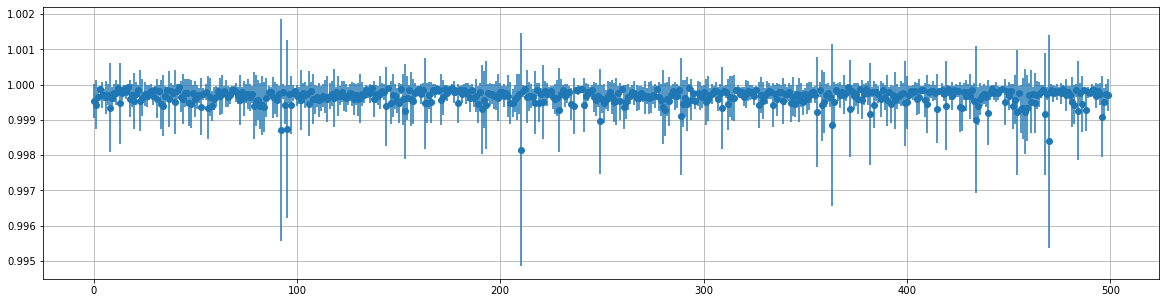

In [73]:
plt.figure(figsize=(20,5))
plt.grid(True)
start_idx = 0
end_idx = 500
xlabels = np.arange(start_idx,end_idx,1)
y_labels = prediction_means[start_idx:end_idx]
error_labels = standard_deviation[start_idx:end_idx]

plt.errorbar(xlabels, y_labels, yerr= error_labels, fmt='o')
#plt.plot(xlabels, error_labels)
plt.show()

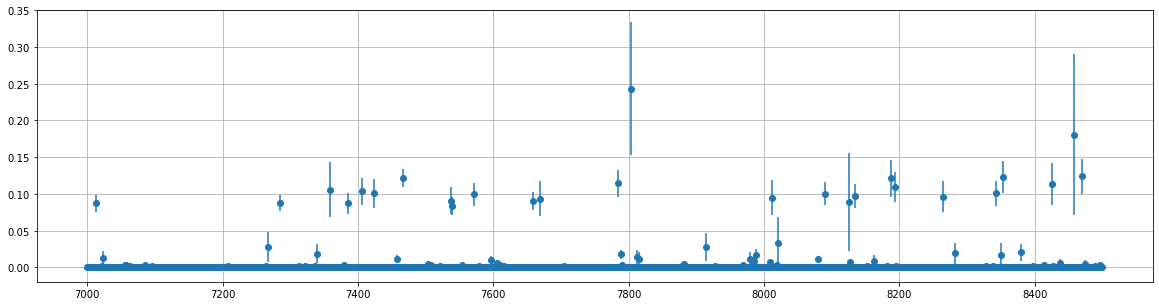

In [74]:
plt.figure(figsize=(20,5))
plt.grid(True)
start_idx = 7000
end_idx = 8500
xlabels = np.arange(start_idx,end_idx,1)
y_labels = prediction_means[start_idx:end_idx]
error_labels = standard_deviation[start_idx:end_idx]

plt.errorbar(xlabels, y_labels, yerr= error_labels, fmt='o')
#plt.plot(xlabels, error_labels)
plt.show()

In [75]:
diff = np.sum(prediction_means.round() - y_test)
print( (num_test_examples -  diff)/num_test_examples)

0.9995884735173356


# Let's test the BNN on data from HOST 0051 . ;)

In [76]:
number_of_prediction_round = 15 
number_of_examples = x_test051full[0].shape[0]

different_host_preds = np.zeros((number_of_prediction_round, number_of_examples))

for i in range(number_of_prediction_round):
    different_host_preds[i] = logit2p(bnn(x_test051full)).flatten()


In [77]:
different_host_mean_preds = np.mean(different_host_preds, axis = 0)
diferent_host_std_dev_preds = np.std(different_host_preds, axis = 0)

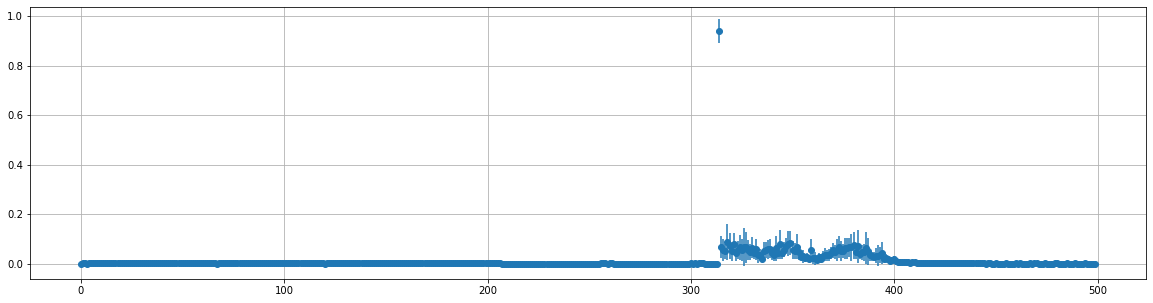

In [78]:
plt.figure(figsize=(20,5))
plt.grid(True)
start_idx = 0
end_idx = 500
xlabels = np.arange(start_idx,end_idx,1)
y_labels = different_host_mean_preds[start_idx:end_idx]
error_labels = diferent_host_std_dev_preds[start_idx:end_idx]

plt.errorbar(xlabels, y_labels, yerr= error_labels, fmt='o')
#plt.plot(xlabels, error_labels)
plt.show()

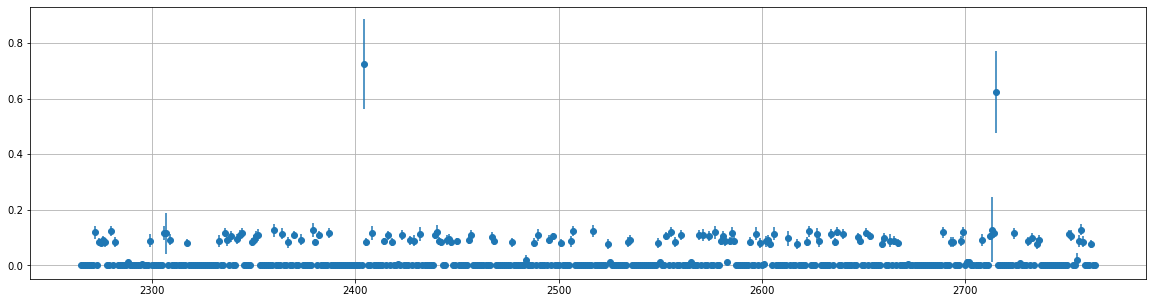

In [79]:
plt.figure(figsize=(20,5))
plt.grid(True)
start_idx = 2265
end_idx = 2765
xlabels = np.arange(start_idx,end_idx,1)
y_labels = different_host_mean_preds[start_idx:end_idx]
error_labels = diferent_host_std_dev_preds[start_idx:end_idx]

plt.errorbar(xlabels, y_labels, yerr= error_labels, fmt='o')
#plt.plot(xlabels, error_labels)
plt.show()

# <p style="font-size:60px;color:white;font-family:'Courier New'" >BAYESAIN NETWORK for host 0051</p>

In [80]:
bnn_0051 = bayesian_model((trace_length,trace_dimension1),(trace_length,trace_dimension2))
bnn_0051.summary()
opt_0051 = tf.optimizers.Adam(learning_rate=0.001)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 4, 3)]       0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 4, 10)]      0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 4, 128)       67584       input_9[0][0]                    
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 4, 256)       273408      input_10[0][0]                   
____________________________________________________________________________________________

In [81]:
#@tf.function
def train_step051(traces, labels):
    with tf.GradientTape() as tape:
        logits = bnn_0051(traces)
        loss = elbo_loss(labels, logits)
    gradients = tape.gradient(loss, bnn_0051.trainable_variables)
    opt_0051.apply_gradients(zip(gradients, bnn_0051.trainable_variables))
    return loss



In [82]:
# Training loop 

times_0051 = []
accs_0051 = []
preds_by_epoch_0051 = []
labels_to_preds_0051 = []
losses_0051 = []

for i in range(100):
    tic = time.time()
    
    X_train, Y_train = train_gen_051.__next__()
    Y_train = Y_train[:, np.newaxis].astype('f')
    
    labels_to_preds_0051.append(Y_train)
    
    loss = train_step051(X_train, Y_train)
    preds = bnn_0051(X_train)
    acc = accuracy(preds, Y_train)
    
    
    
    accs_0051.append(acc)
    losses_0051.append(loss)
    preds_by_epoch_0051.append(logit2p(preds))
  
    tac = time.time()
    train_time = tac-tic
    times_0051.append(train_time)
    if i%10 == 0 :
        print("Epoch: {}: loss = {:7.3f} , accuracy = {:7.3f}, time: {:7.3f}".format(i, loss, acc, train_time))

Epoch: 0: loss =   2.776 , accuracy =   0.596, time:   0.472
Epoch: 10: loss =   0.365 , accuracy =   0.748, time:   0.356
Epoch: 20: loss =   0.240 , accuracy =   0.893, time:   0.339
Epoch: 30: loss =   0.139 , accuracy =   0.987, time:   0.362
Epoch: 40: loss =   0.122 , accuracy =   0.982, time:   0.401
Epoch: 50: loss =   0.080 , accuracy =   0.990, time:   0.398
Epoch: 60: loss =   0.047 , accuracy =   0.995, time:   0.425
Epoch: 70: loss =   0.029 , accuracy =   0.993, time:   0.451
Epoch: 80: loss =   0.015 , accuracy =   0.998, time:   0.408
Epoch: 90: loss =   0.018 , accuracy =   0.995, time:   0.456


In [83]:
number_of_prediction_round = 10
num_test_examples_051 = x_test051[0].shape[0]

test_predictions_051 = np.zeros((number_of_prediction_round, num_test_examples_051))

for i in range(number_of_prediction_round):
    test_predictions_051[i] = logit2p(bnn_0051(x_test051)).flatten()

prediction_means051 = np.mean(test_predictions_051, axis = 0)
standard_deviation051 = np.std(test_predictions_051, axis = 0)

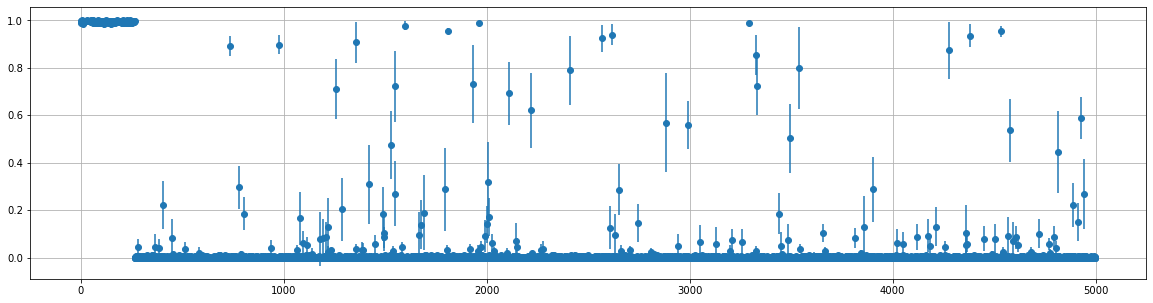

In [84]:
plt.figure(figsize=(20,5))
plt.grid(True)
start_idx = 0
end_idx = 5000
xlabels = np.arange(start_idx,end_idx,1)
y_labels = prediction_means051[start_idx:end_idx]
error_labels = standard_deviation051[start_idx:end_idx]

plt.errorbar(xlabels, y_labels, yerr= error_labels, fmt='o')
#plt.plot(xlabels, error_labels)
plt.show()

In [85]:
number_of_prediction_round = 10
num_test_examples_201= x_test[0].shape[0]

test_predictions_201 = np.zeros((number_of_prediction_round, num_test_examples_201))

for i in range(number_of_prediction_round):
    test_predictions_201[i] = logit2p(bnn_0051(x_test)).flatten()

prediction_means201 = np.mean(test_predictions_201, axis = 0)
standard_deviation201 = np.std(test_predictions_201, axis = 0)

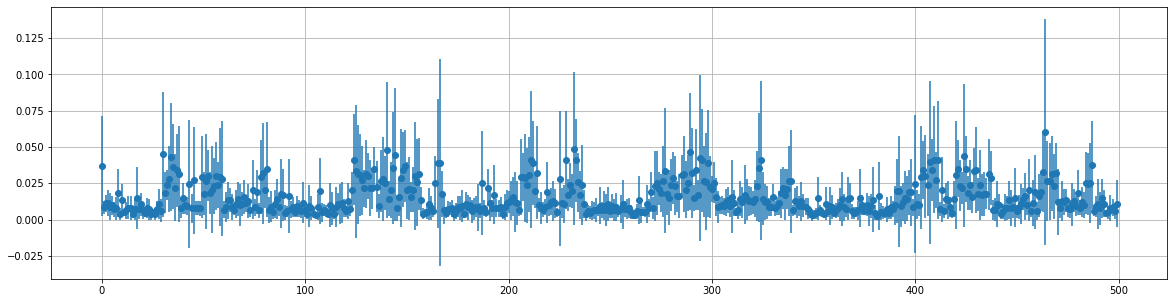

In [86]:
plt.figure(figsize=(20,5))
plt.grid(True)
start_idx = 0
end_idx = 500
xlabels = np.arange(start_idx,end_idx,1)
y_labels = prediction_means201[start_idx:end_idx]
error_labels = standard_deviation201[start_idx:end_idx]

plt.errorbar(xlabels, y_labels, yerr= error_labels, fmt='o')
#plt.plot(xlabels, error_labels)
plt.show()

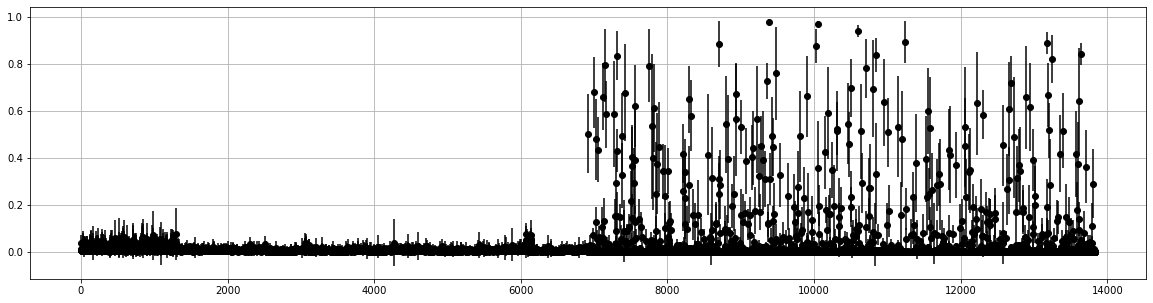

In [87]:
plt.figure(figsize=(20,5))
plt.grid(True)
start_idx = 0
end_idx = 2*6919
xlabels = np.arange(start_idx,end_idx,1)
y_labels = prediction_means201[start_idx:end_idx]
error_labels = standard_deviation201[start_idx:end_idx]

plt.errorbar(xlabels, y_labels, yerr= error_labels, fmt='ko')
#plt.plot(xlabels, error_labels)
plt.show()

In [88]:
# import os
# model_folder = '/mnt/8tb/csenrc/data/ecar/benign/MonowarNNModel'
# bnn_201_path = os.path.join(model_folder,'bnn_201.h5')
# bnn.save(bnn_201_path)
# bnn_0051_path = os.path.join(model_folder, 'bnn_051.h5')
# bnn_0051.save(bnn_0051_path)

In [89]:
number_of_prediction_round = 10
num_test_examples_501= x_test501[0].shape[0]

test_predictions_501 = np.zeros((number_of_prediction_round, num_test_examples_501))

for i in range(number_of_prediction_round):
    test_predictions_501[i] = logit2p(bnn_0051(x_test501)).flatten()

prediction_means501 = np.mean(test_predictions_501, axis = 0)
standard_deviation501 = np.std(test_predictions_501, axis = 0)

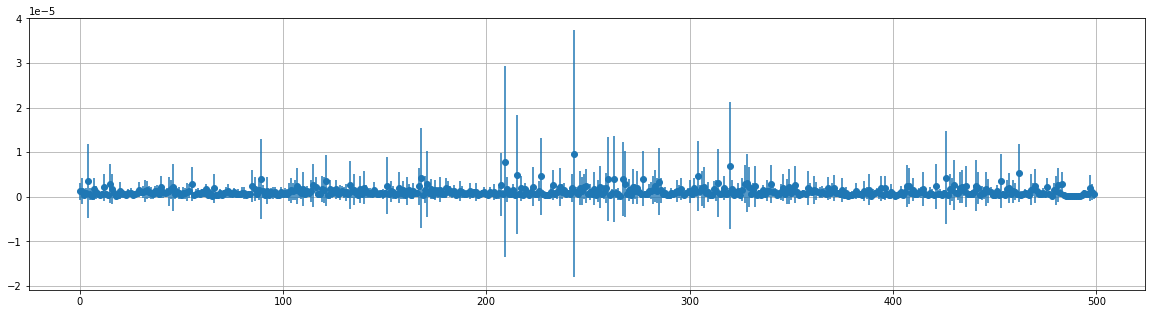

In [90]:
plt.figure(figsize=(20,5))
plt.grid(True)
start_idx = 0
end_idx = 500
xlabels = np.arange(start_idx,end_idx,1)
y_labels = prediction_means501[start_idx:end_idx]
error_labels = standard_deviation501[start_idx:end_idx]

plt.errorbar(xlabels, y_labels, yerr= error_labels, fmt='o')
#plt.plot(xlabels, error_labels)
plt.show()

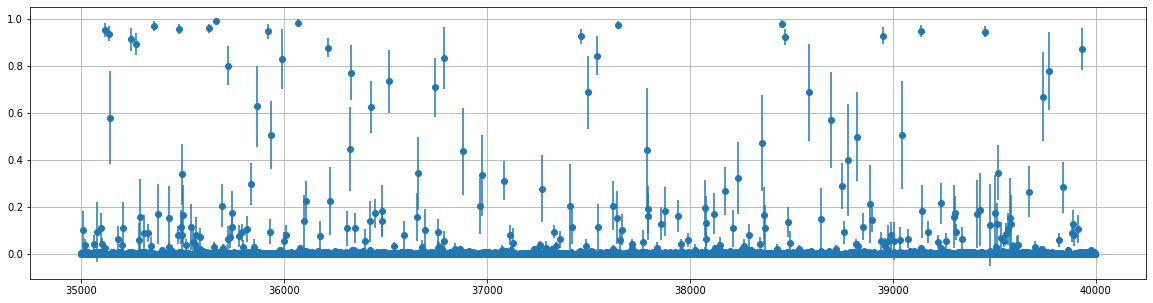

In [99]:
plt.figure(figsize=(20,5))
plt.grid(True)
start_idx = 35000
end_idx = 40000
xlabels = np.arange(start_idx,end_idx,1)
y_labels = prediction_means501[start_idx:end_idx]
error_labels = standard_deviation501[start_idx:end_idx]

plt.errorbar(xlabels, y_labels, yerr= error_labels, fmt='o')
#plt.plot(xlabels, error_labels)
plt.show()